## Hyperopt results

To improve the agreement between the MC and GAN distributions as well as the correlations between the input features **Hyperopt** ([http://hyperopt.github.io](http://hyperopt.github.io)) has been used on several parameters.

In [11]:
import tensorflow as tf
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import glob

import readLHE
import invariants
from plot_helper import plt_inv, plt_corr

The selected training parameters for the Hyperopt optimization are:
- Batch size of the input sample;
- Starting learning rate of the optimizer;
- Number of epochs;
- Optimizer;
- Preprocessing: StandardScaler or PowerTransformer + MinMaxScaler.

In [12]:
batch_size = [128, 256, 512]
learning_rate = [0.1, 0.01, 0.001]
epochs = [3e4, 4e4, 5e4]
optimizer = ['SGD', 'RMSprop', 'Adagrad']

parameters = [batch_size, epochs, learning_rate]

In [13]:
with open('trials/trials.pickle', 'rb') as file, open('trials/trials_std.pickle', 'rb') as file_std:
    trials = pickle.load(file)
    trials_std = pickle.load(file_std)

#creo dataframe con i trials
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]) for t in trials])
trials_std_df = pd.DataFrame([pd.Series(t['misc']['vals']) for t in trials_std])
for key in trials_df.keys():
    trials_df[key] =  [item for sublist in trials_df[key] for item in sublist]
    trials_std_df[key] =  [item2 for sublist2 in trials_std_df[key] for item2 in sublist2]

#aggiungo la kl-div
a = []
b = []
for t in trials_std:
    a.append(t['result']['loss'])
for s in trials:
    b.append(s['result']['loss'])

trials_df = trials_df.drop(labels='optimizer', axis=1)
trials_std_df = trials_std_df.drop(labels='optimizer', axis=1)

for i in range(len(trials_df.keys())):
    trials_df[trials_df.keys()[i]] = [parameters[i][j] for j in trials_df[trials_df.keys()[i]]]
trials_df['preprocess'] = 'MinMax'
trials_df['loss'] = b

for i in range(len(trials_std_df.keys())):
    trials_std_df[trials_std_df.keys()[i]] = [parameters[i][j] for j in trials_std_df[trials_std_df.keys()[i]]]
trials_std_df['preprocess'] = 'Standard'
trials_std_df['loss'] = a

The loss function used to evaluate the Hyperopt trial is the **Kullback-Leibler divergence**. To better study the density of points, I divided the trials for preprocessing used. The total number of evaluations is 100. However, the KL-div in the following plots is cut because some training ended in the failure modes. 

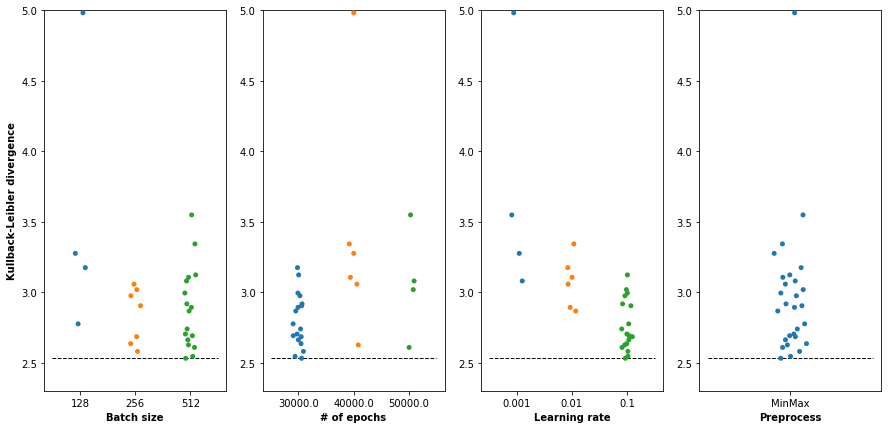

In [14]:
labels = ['Batch size', '# of epochs', 'Learning rate', 'Preprocess']
fig, axes = plt.subplots(1,4, figsize=(15,7))
for i in range(0, len(labels)):
    g = sns.stripplot(ax=axes[i], x=trials_df.keys()[i], y='loss', data=trials_df)
    if i==3:
        axes[i].hlines(min(trials_df['loss']), -0.5, 0.5, linestyle='--', linewidth=1)
    else:
        axes[i].hlines(min(trials_df['loss']), -0.5, 2.5, linestyle='--', linewidth=1)
    axes[i].set_ylim(2.3, 5)
    axes[i].set_xlabel(labels[i], fontweight='bold')
    axes[i].set_ylabel('')
    axes[0].set_ylabel('Kullback-Leibler divergence', rotation='vertical', fontweight='bold')

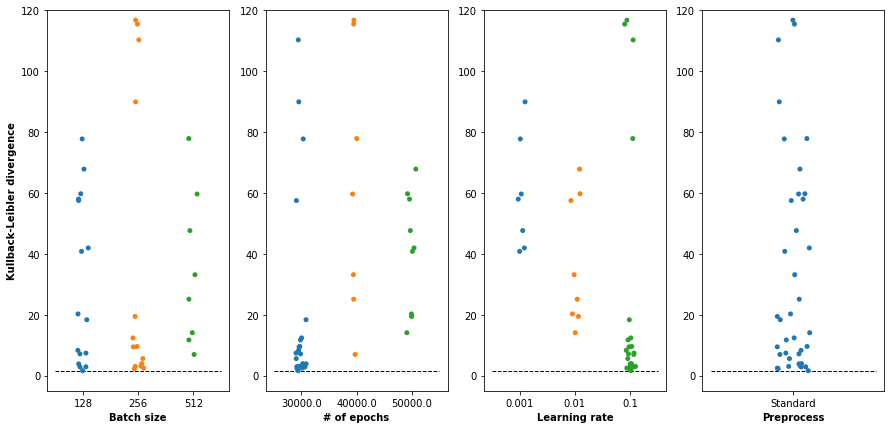

In [15]:
labels = ['Batch size', '# of epochs', 'Learning rate', 'Preprocess']
fig, axes = plt.subplots(1,4, figsize=(15,7))
for i in range(0, len(labels)):
    g = sns.stripplot(ax=axes[i], x=trials_std_df.keys()[i], y='loss', data=trials_std_df)
    if i==3:
        axes[i].hlines(min(trials_std_df['loss']), -0.5, 0.5, linestyle='--', linewidth=1)
    else:
        axes[i].hlines(min(trials_std_df['loss']), -0.5, 2.5, linestyle='--', linewidth=1)
    axes[i].set_ylim(-5, 120)
    axes[i].set_xlabel(labels[i], fontweight='bold')
    axes[i].set_ylabel('')
    axes[0].set_ylabel('Kullback-Leibler divergence', rotation='vertical', fontweight='bold')

The main trend outlined above is that the *Standard* preprocessing has a wider density with the same KL-div minimum. Thus, the **PowerTransformer + MinMax** pipeline is preferred and it is used from now on. The other parameters suggest that the minimum is already reached around 30k epochs and that high learning rates and batch sizes are preferred.

Once fixed the preprocessing, the batch size, and the number of epochs, a second optimization, with 300 evaluations, has been performed to find a more clear trend of the learning rate and to replace the standard SGD optimization algorithm. The chosen possible parameters are:
- Optimizer: Adam, Adamax, Adagrad, and Adadelta;
- Learning rate: Log uniform distribution in (0,1];

In [16]:
opt = ['Adam', 'Adamax', 'Adagrad', 'Adadelta']
with open('trials/trials_lr.pickle', 'rb') as file:
    trials_lr = pickle.load(file)

#creo dataframe con i trials
trials_lr_df = pd.DataFrame([pd.Series(t['misc']['vals']) for t in trials_lr])
for key in trials_lr_df.keys():
    trials_lr_df[key] =  [item2 for sublist2 in trials_lr_df[key] for item2 in sublist2]

#aggiungo la kl-div
c = []
for t in trials_lr:
    c.append(t['result']['loss'])

trials_lr_df = trials_lr_df.drop(labels='epochs', axis=1)
    
trials_lr_df['optimizer'] = [opt[i] for i in trials_lr_df['optimizer']]
trials_lr_df['loss'] = c

Text(0, 0.5, '')

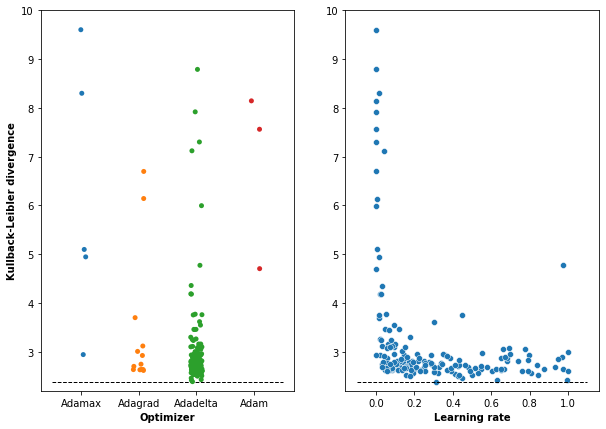

In [17]:
h_ranges = [ (-0.5, 3.5)]
fig, axes = plt.subplots(1,2, figsize=(10,7))
g = sns.stripplot(ax=axes[0], x='optimizer', y='loss', data=trials_lr_df)
axes[0].hlines(min(trials_lr_df['loss']), -0.5, 3.5, linestyle='--', linewidth=1)
axes[0].set_ylim(2.2, 10)
axes[0].set_xlabel('Optimizer', fontweight='bold')
axes[0].set_ylabel('Kullback-Leibler divergence', rotation='vertical', fontweight='bold')
g = sns.scatterplot(data=trials_lr_df, x='learning_rate', y='loss', ax=axes[1])
g.set_ylim(2.2, 10)
axes[1].hlines(min(trials_lr_df['loss']), -0.1, 1.1, linestyle='--', linewidth=1)
axes[1].set_xlabel('Learning rate', fontweight='bold')
axes[1].set_ylabel('')

After this second optimization, it is clear that **Adadelta** is the best optimizer to use and that a learning rate **> 0.1** does not play a fundamental role in the convergence to the minimum.

### Optimized features reconstruction

Here are reported the distributions obtained according to the best KL-div in the optimization phase with a training sample of 10k events:
- Batch size: 512;
- Learning rate: 0.3;
- Optimizer: Adadelta;
- Number of epochs: ~30000;
- Preprocessing: PowerTransformer + MinMax;

In [21]:
file = '../../samples/ppttbar_10k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar_10k = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar_10k[i,0] = invariants.GetEnergySquared(ev)
    invar_10k[i,1] = invariants.GetMandelT(ev)
    invar_10k[i,2] = invariants.GetRapidity(init, ev)
    i += 1

with open('dcgan-ppttbar-10k/outputs/preprocess/pipeline.pickle', 'rb') as pipe:
    pipeline = pickle.load(pipe)

#Genero 10k eventi e applico il post-processing
gen = tf.keras.models.load_model('dcgan-ppttbar-10k/outputs/generator.h5', compile=False)
pred_opt = gen.predict(tf.random.uniform([10000, 100]), batch_size=1024)
pred_opt = pipeline.inverse_transform(pred_opt)

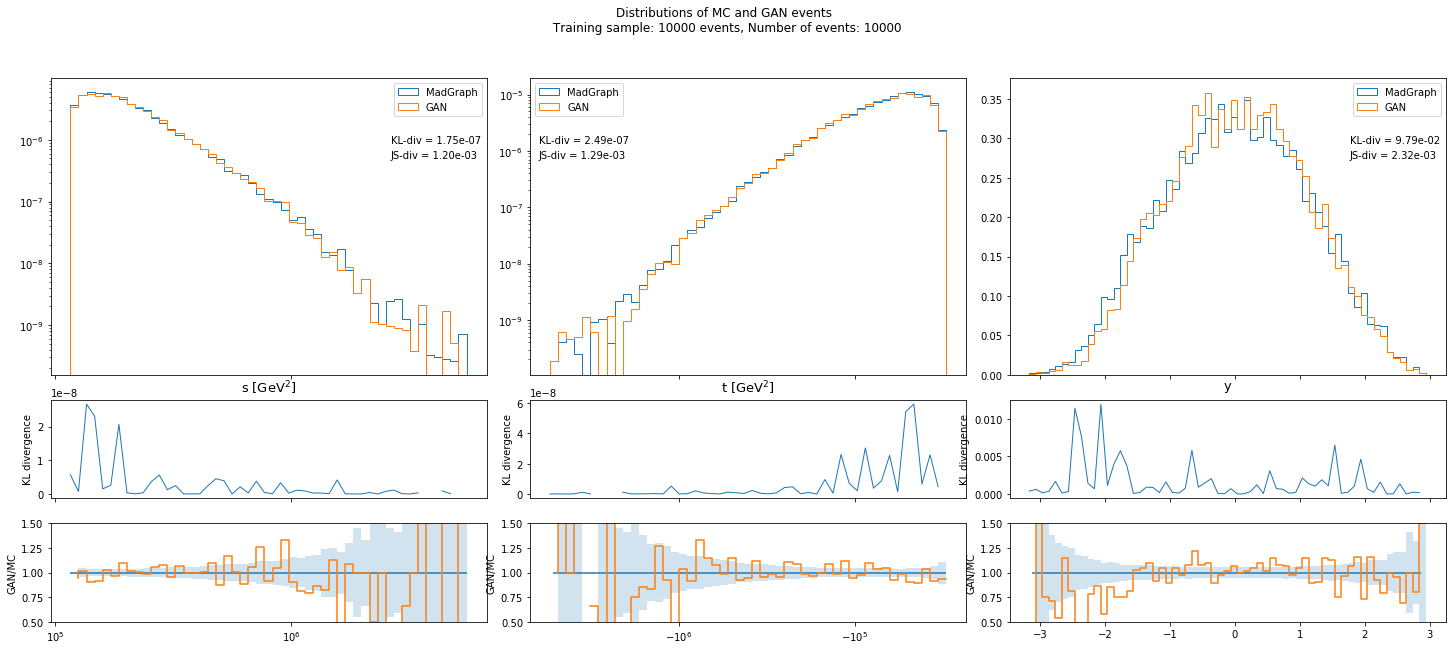

In [22]:
plt_inv(invar_10k, pred_opt, len(invar_10k))

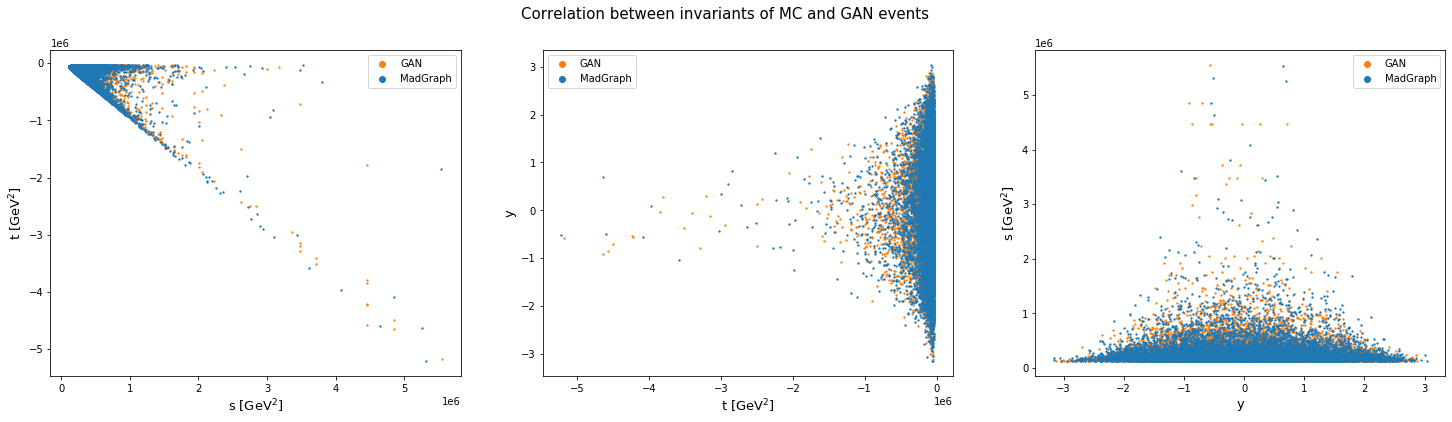

In [23]:
plt_corr(invar_10k, pred_opt)